C:\Users\shubh\AppData\Local\Temp\ipykernel_24120\2250884966.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = merged.groupby('classification')['Closed PnL'].agg(['mean', 'sum', 'count']).reset_index()


Summary stats by sentiment:
   classification          mean           sum  count
0   Extreme Fear  52793.589178  7.391102e+05     14
1  Extreme Greed  23817.292199  2.715171e+06    114
2           Fear  36891.818040  3.357155e+06     91
3          Greed  11140.566181  2.150129e+06    193
4        Neutral  19297.323516  1.292921e+06     67

T-test: t-statistic=2.3242, p-value=0.0217


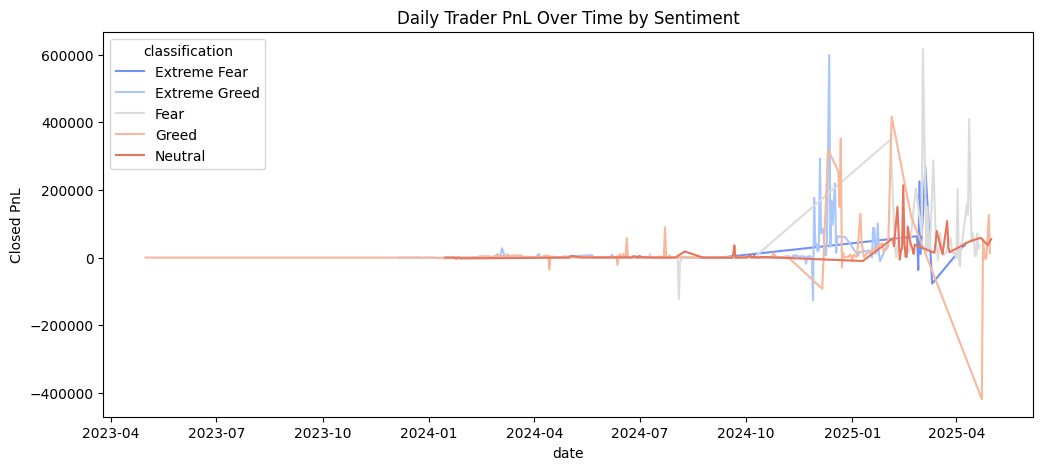

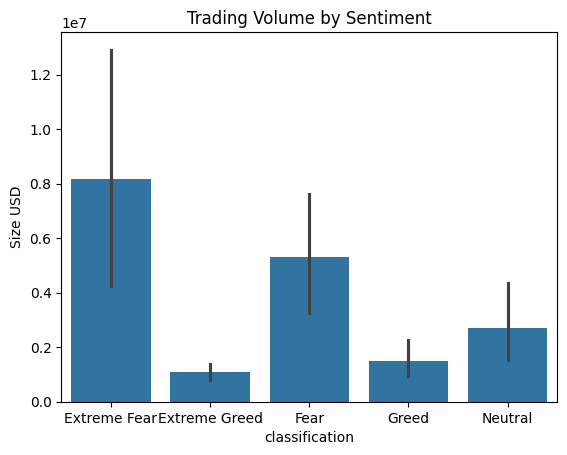

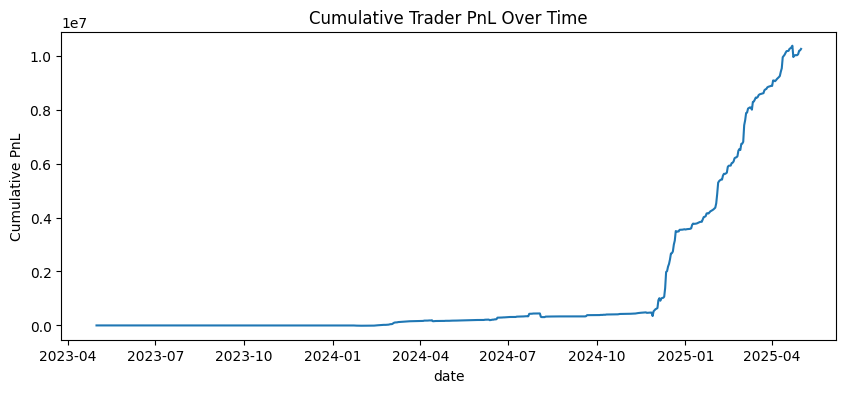

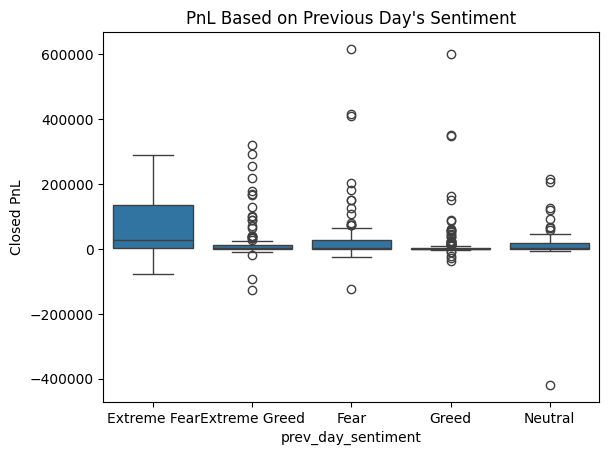

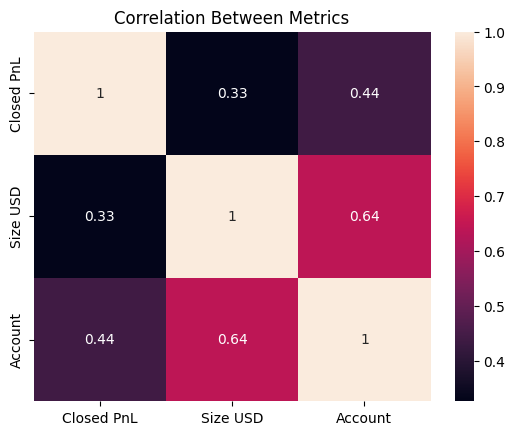

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Load data
sentiment_df = pd.read_csv('../data/fear_greed_index.csv')
trader_df = pd.read_csv('../data/historical_data.csv')

# Parse dates
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
trader_df['date'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M').dt.floor('D')
trader_df['Side'] = trader_df['Side'].str.lower()

# Group trader data daily
daily = trader_df.groupby('date').agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Account': 'nunique'
}).reset_index()

# Merge with sentiment
sentiment_df['classification'] = sentiment_df['classification'].astype('category')
merged = pd.merge(daily, sentiment_df, on='date', how='inner')

# 1. Summary stats
summary = merged.groupby('classification')['Closed PnL'].agg(['mean', 'sum', 'count']).reset_index()
print("Summary stats by sentiment:\n", summary)

# 2. Statistical significance test
fear = merged[merged['classification'] == 'Fear']['Closed PnL']
greed = merged[merged['classification'] == 'Greed']['Closed PnL']
t_stat, p_val = ttest_ind(fear, greed, equal_var=False)
print(f"\nT-test: t-statistic={t_stat:.4f}, p-value={p_val:.4f}")

# 3. Time series comparison
plt.figure(figsize=(12,5))
sns.lineplot(data=merged, x='date', y='Closed PnL', hue='classification', palette='coolwarm')
plt.title('Daily Trader PnL Over Time by Sentiment')
plt.show()

# 4. Leverage analysis (if available)
if 'Leverage' in trader_df.columns:
    daily_leverage = trader_df.groupby('date')['Leverage'].mean().reset_index()
    merged = merged.merge(daily_leverage, on='date', how='left')
    plt.figure()
    sns.boxplot(data=merged, x='classification', y='Leverage')
    plt.title("Average Leverage by Market Sentiment")
    plt.show()

# 5. Trading volume comparison
plt.figure()
sns.barplot(data=merged, x='classification', y='Size USD')
plt.title('Trading Volume by Sentiment')
plt.show()

# 6. Cumulative profit over time
merged = merged.sort_values('date')
merged['Cumulative PnL'] = merged['Closed PnL'].cumsum()
plt.figure(figsize=(10,4))
sns.lineplot(data=merged, x='date', y='Cumulative PnL')
plt.title("Cumulative Trader PnL Over Time")
plt.show()

# 7. Sentiment lag analysis
merged['prev_day_sentiment'] = merged['classification'].shift(1)
plt.figure()
sns.boxplot(data=merged, x='prev_day_sentiment', y='Closed PnL')
plt.title("PnL Based on Previous Day's Sentiment")
plt.show()

# 8. Segment by symbol (if available)
if 'Symbol' in trader_df.columns:
    symbol_pnl = trader_df.groupby(['date', 'Symbol']).agg({'Closed PnL': 'sum'}).reset_index()
    symbol_merged = pd.merge(symbol_pnl, sentiment_df, on='date', how='left')
    plt.figure(figsize=(10,5))
    sns.boxplot(data=symbol_merged, x='classification', y='Closed PnL', hue='Symbol')
    plt.title("Symbol Performance by Sentiment")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

# 9. Correlation heatmap
plt.figure()
sns.heatmap(merged[['Closed PnL', 'Size USD', 'Account']].corr(), annot=True)
plt.title("Correlation Between Metrics")
plt.show()
